This notebook will be used to test and get the best model parameters for CEBRA

In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [2]:
import sys
import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import torch

from matplotlib.collections import LineCollection
import pandas as pd

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


### 1. Base cebra model 

Let's start with a base CEBRA model that we'll use and modify to get the best embeddings.

In [3]:
iterations = 2000

In [4]:
def base_embed(input, temp=1, dimension=3, lr = 0.01, d=0.1):

    # build CEBRA time model
    model = CEBRA(model_architecture='offset1-model',
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         delta=int(d),
                         conditional='time',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True,
                         time_offsets=1)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

In this notebook we'll use the simple circle then the lorenz attractor as input

In [5]:

# function to make a circle, that takes in number of data-points
def make_circle(n_points=100, r=1):

    # Define the center and radius of the circle
    center = (0, 0)
    radius = r

    # Create an array of angles from 0 to 2*pi
    theta = np.linspace(0, 2*np.pi, n_points)

    # Calculate the x and y coordinates of the circle
    x = center[0] + radius * np.cos(theta)
    x = x.reshape(-1,1)

    y = center[1] + radius * np.sin(theta)
    y = y.reshape(-1,1)

    # add the 3rd dimension (z coordinate of 0)
    z = np.zeros(n_points)
    z = z.reshape(-1,1)

    circle = np.concatenate((x,y,z), axis=1)

    return circle

# function to plot the circle
def plot_circle(x,y,z=0):
    # Create a figure and axis
    fig = plt.figure()
    ax = plt.subplot(111,projection='3d')
    # Plot the circle
    ax.plot(x, y, z, label='Circle')

    # Show the plot
    plt.show()



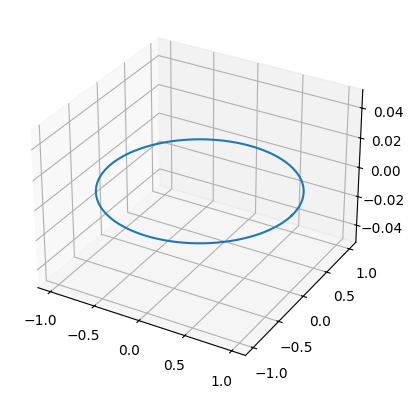

(100, 3)

In [6]:
%matplotlib inline
circle = make_circle()
plot_circle(circle[:,0], circle[:,1])
circle.shape

In [7]:
# define a function to make a lorenz system
def lorenz(t, xyz, sigma=10, rho=28, beta=8/3):
    x, y, z = xyz
    dxdt = sigma * (y - x)
    dydt = rho * x - y - x * z
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]


# Define parameters and initial conditions
sigma = 10
rho = 28
beta = 8/3
initial_conditions = [0, 2, 0]  # Initial conditions for [x, y, z]

# Time span for integration
t_span = [0, 35]

# Solve the differential equations
solution = solve_ivp(lorenz, t_span, initial_conditions, args=(sigma, rho, beta), dense_output=True)

# Generate time points for plotting
t = np.linspace(t_span[0], t_span[1], 10000)

# Evaluate the solution at the time points
xyz = solution.sol(t)


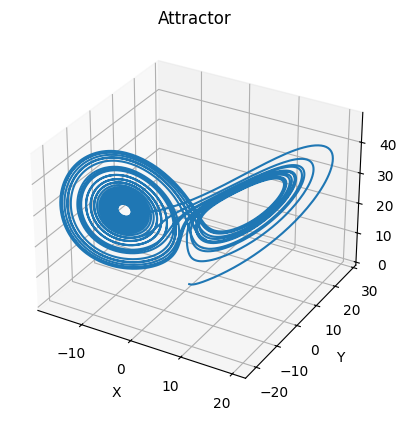

In [8]:
# Plot the Lorenz attractor
def plot_lorenz(coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(coords[0], coords[1], coords[2], alpha=1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Attractor')
    plt.show()


plot_lorenz(xyz)

In [11]:
# reshape the lorenz object for use with cebra
new_lorenz = np.transpose(xyz)

### 2.Play with different temperature values and plot the embeddings produced

Let's start by computing embeddings for the circle and the lorenz attractor using the base model.

In [13]:
model_c3, embedc3 = base_embed(circle,temp=1,dimension=3)
model_l3, embedl3 = base_embed(new_lorenz,temp=1,dimension=3)

  0%|          | 0/2000 [00:00<?, ?it/s]

pos:  0.0000 neg:  6.2274 total:  6.2274 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 90.42it/s]
pos:  0.0001 neg:  6.1104 total:  6.1105 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 91.50it/s]


<Axes3D: title={'center': 'Embedding'}>

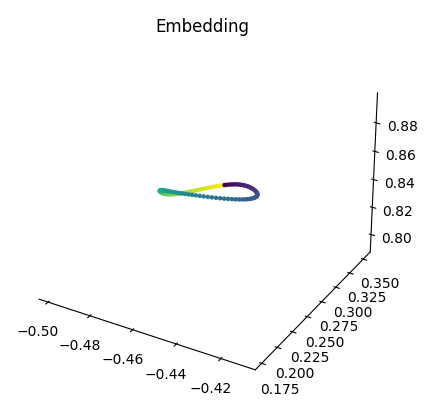

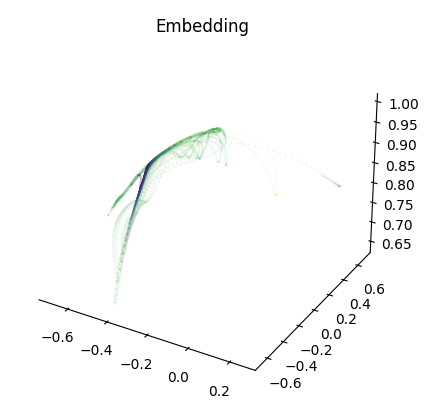

In [14]:
cebra.plot_embedding(embedc3, embedding_labels='time', markersize=5, alpha=1)
cebra.plot_embedding(embedl3,  embedding_labels='time', markersize=0.001, alpha=1)

Now, we define a function to search for rough estimates for the ideal temperature value.

In [15]:
def opt_temp(data, temperature_values, s = 5, delta=0.1):
    
    fig=plt.figure(figsize=(8,4*int(len(temperature_values))))

    for i, temperature in enumerate(temperature_values):
        # make embeddings
        model2, embedding2 = base_embed(input=data,temp=temperature,dimension=2,d=delta)
        model3, embedding3 = base_embed(input=data,temp=temperature,dimension=3,d=delta)

        # define the grid
        gs = gridspec.GridSpec(len(temperature_values), 2, figure=fig)

        # plot and label embeddings
        
        ax2 = fig.add_subplot(gs[1*i,0])
        cebra.plot_embedding(embedding2, embedding_labels='time', markersize=s, alpha=1,ax=ax2, title='2D, t={}'.format(temperature))
        ax3 = fig.add_subplot(gs[1*i,1], projection='3d')
        cebra.plot_embedding(embedding3, embedding_labels='time', markersize=s, alpha=1,ax=ax3, title='3D, t={}'.format(temperature))
        plt.tight_layout()
        
    plt.show()

Generate a set of temperature values to check for the circle input and run the function for these values

In [16]:
# define some temp values to iterate over
# t_values = np.linspace(1,1000,5)
# t_values
t_values = np.array([0.001,0.01,0.1,1])

pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:22<00:00, 90.73it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.22it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.65it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:20<00:00, 95.25it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.67it/s]
pos:  nan neg:  nan total:  nan temperature:  0.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.89it/s]
pos:  0.0000 neg:  6.2345 total:  6.2345 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.67it/s]
pos:  0.0000 neg:  6.2159 total:  6.2160 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.34it/s]


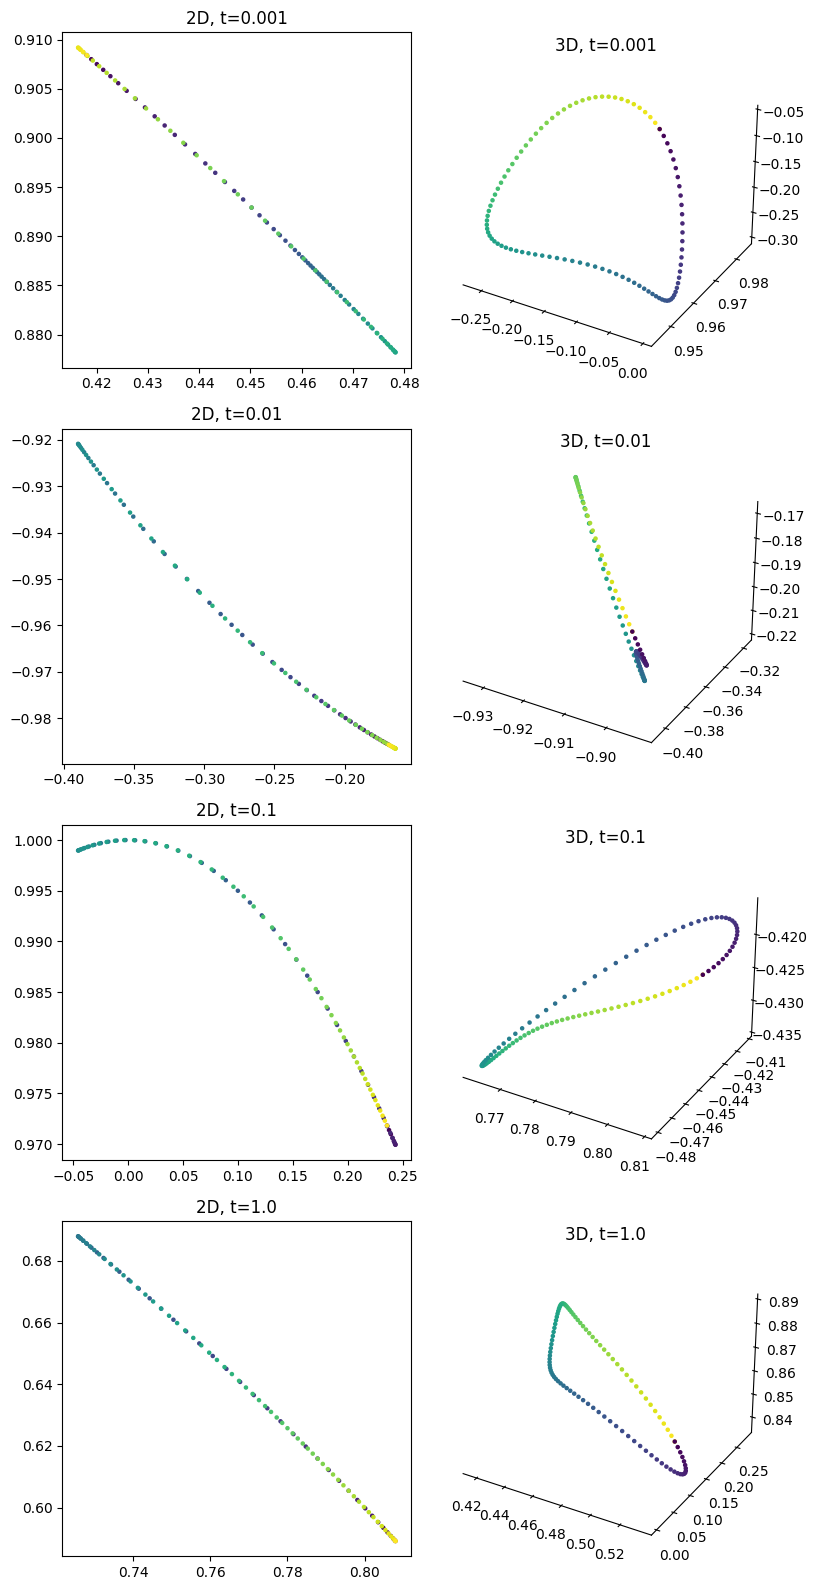

In [16]:
opt_temp(circle,t_values)

Now do the same for the lorenz attractor. Generate a set of temperature values to check and run the function for these values

In [17]:
tl_values = np.linspace(1,10,5)
tl_values


array([ 1.  ,  3.25,  5.5 ,  7.75, 10.  ])

pos:  0.0064 neg:  5.6928 total:  5.6992 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.96it/s]
pos:  0.0022 neg:  5.6870 total:  5.6892 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.27it/s]
pos:  0.0024 neg:  5.7144 total:  5.7168 temperature:  3.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.80it/s]
pos:  0.0003 neg:  6.1844 total:  6.1847 temperature:  3.0000: 100%|██████████| 2000/2000 [00:21<00:00, 94.71it/s]
pos:  0.0001 neg:  6.1318 total:  6.1319 temperature:  5.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.71it/s]
pos:  0.0012 neg:  5.9817 total:  5.9829 temperature:  5.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.58it/s]
pos:  0.0005 neg:  6.1710 total:  6.1714 temperature:  7.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.89it/s]
pos:  0.0002 neg:  6.0308 total:  6.0310 temperature:  7.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.68it/s]
pos:  0.0002 neg:  6.1919 total:  6.1921 temperature:  10.0000: 100%|██████████|

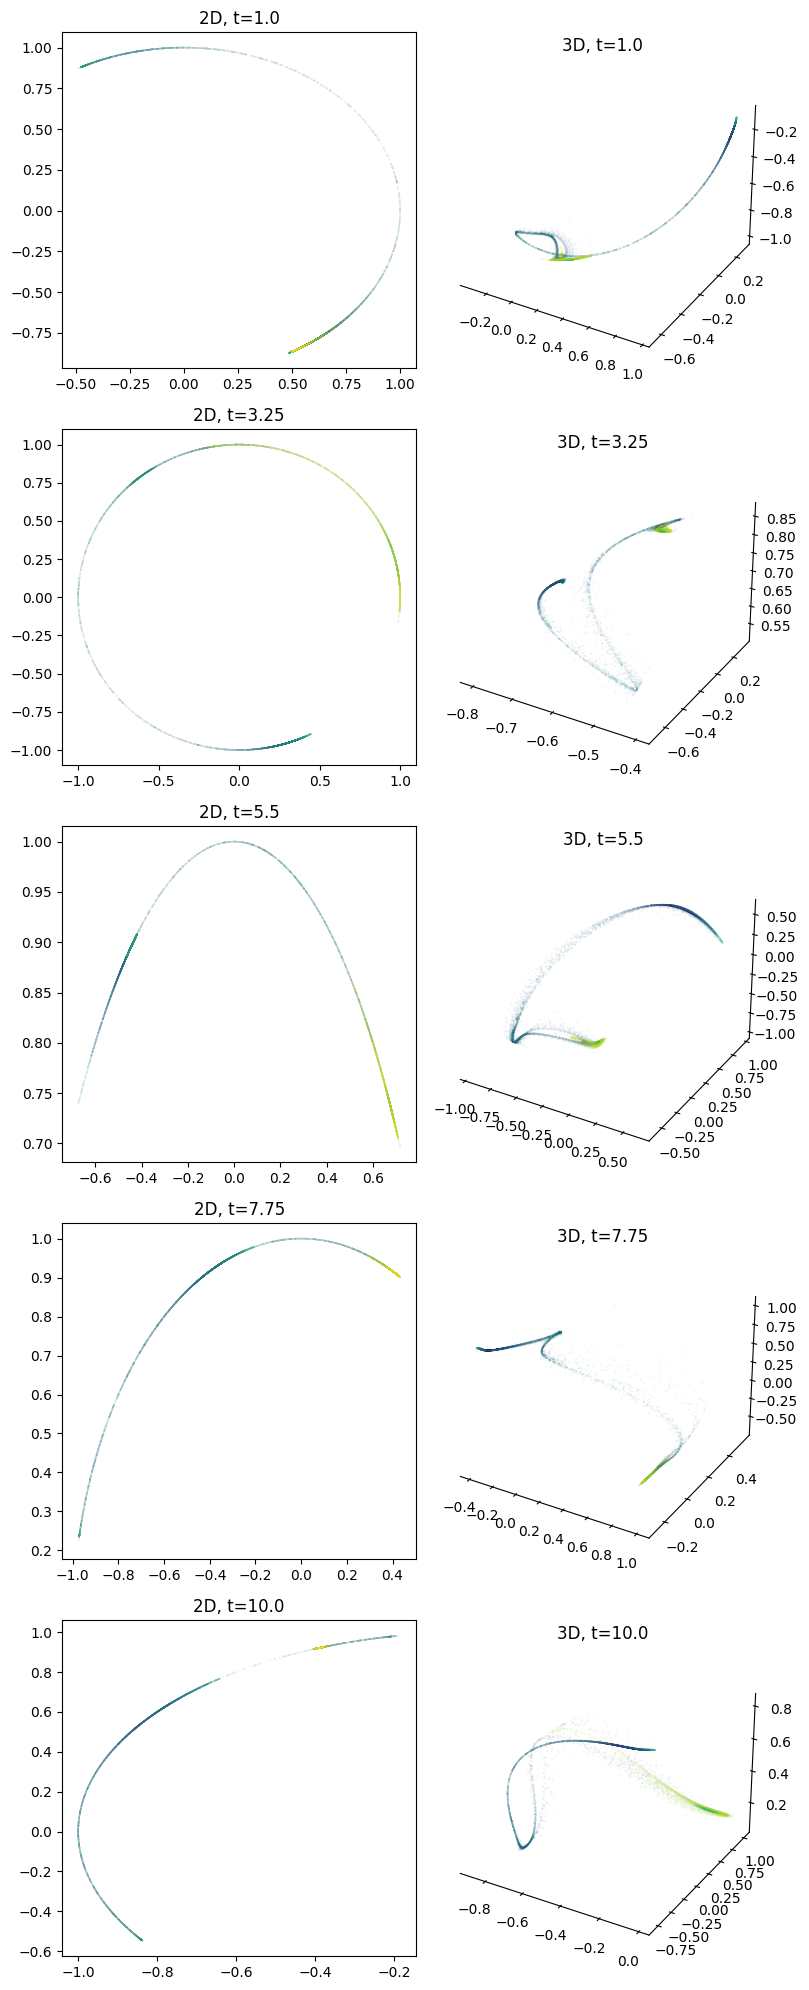

In [18]:
# now optimize for the best temperature value for the attractor
opt_temp(new_lorenz,tl_values,s=0.001, delta=1)

Compare the embeddings produced with 'constant' temperature mode and 'auto'

### 3. Do the same for other parameters starting with the learning rate

In this section, we search for a rough estimate of the ideal learning rate to use. Using knowledge about good temperature values to use from the previous section, we create a function that iterates over different learning rate values and displays the generated embeddings.

In [19]:
# use the optimum value for the temperature found earlier
best_t = 1
best_tl = 1

Start by defining a set of lr values to test on the circle input. Then we make a function that iterates over this values and computes embeddings, keeping all other parameters constant.

In [20]:
# lrs = np.linspace(0.0001,1,10)
# lrs
lrs = np.array([0.0001,0.001,0.01,0.1,1])


In [21]:
def opt_lr(data, lr_values, t=best_t, delta=0.1,s=5):

    fig=plt.figure(figsize=(8,4*int(len(lr_values))))

    for i, value in enumerate(lr_values):
        # make embeddings
        model2, embedding2 = base_embed(input=data,temp=t,dimension=2,lr=value,d=delta)
        model3, embedding3 = base_embed(input=data,temp=t,dimension=3,lr=value, d=delta)

        # define the grid
        gs = gridspec.GridSpec(len(lr_values), 2, figure=fig)

        # plot and label embeddings
        
        ax2 = fig.add_subplot(gs[1*i,0])
        cebra.plot_embedding(embedding2, embedding_labels='time', markersize=s, alpha=1,ax=ax2, title='2D, lr={}'.format(value))
        ax3 = fig.add_subplot(gs[1*i,1], projection='3d')
        cebra.plot_embedding(embedding3, embedding_labels='time', markersize=s, alpha=1,ax=ax3, title='3D, lr={}'.format(value))
        plt.tight_layout()
        
    plt.show()

pos:  0.0000 neg:  6.2176 total:  6.2176 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.79it/s]
pos:  0.0000 neg:  6.2359 total:  6.2359 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.30it/s]
pos:  0.0000 neg:  6.2216 total:  6.2217 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.99it/s]
pos:  0.0000 neg:  6.2302 total:  6.2302 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.27it/s]
pos:  0.0000 neg:  6.2318 total:  6.2318 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.94it/s]
pos:  0.0001 neg:  6.2049 total:  6.2050 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.44it/s]
pos:  0.0000 neg:  6.2235 total:  6.2236 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 91.11it/s]
pos:  0.0000 neg:  6.2298 total:  6.2298 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.63it/s]
pos:  0.0144 neg:  5.0753 total:  5.0897 temperature:  1.0000: 100%|██████████| 

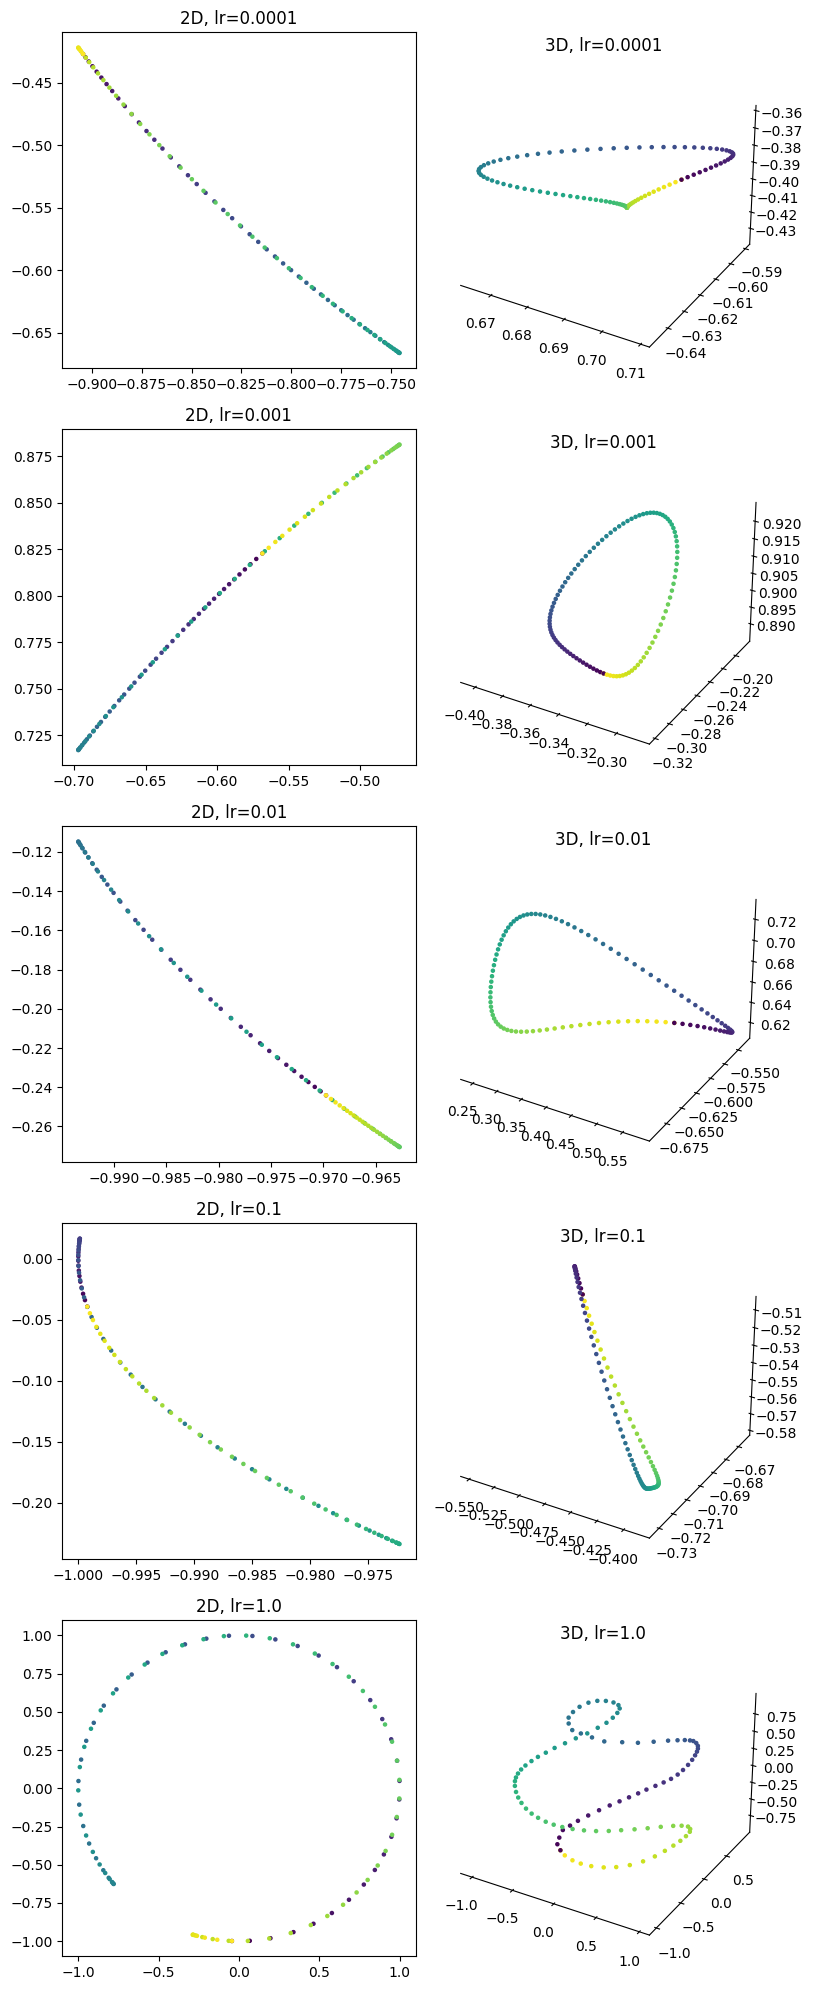

In [22]:
# try it on the circle input
opt_lr(circle,lrs)

Then we do the same thing for the lorenz input

pos:  0.0000 neg:  6.2290 total:  6.2290 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.12it/s]
pos:  0.0020 neg:  5.6388 total:  5.6408 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.57it/s]
pos:  0.0080 neg:  5.2916 total:  5.2996 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 91.99it/s]
pos:  0.0005 neg:  5.7810 total:  5.7815 temperature:  1.0000: 100%|██████████| 2000/2000 [00:22<00:00, 90.39it/s]
pos:  0.0008 neg:  5.8544 total:  5.8552 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 91.50it/s]
pos:  0.0138 neg:  5.4815 total:  5.4954 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 91.24it/s]
pos:  0.0045 neg:  5.6119 total:  5.6163 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.34it/s]
pos:  0.0012 neg:  5.8463 total:  5.8476 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.12it/s]
pos:  0.0055 neg:  5.0765 total:  5.0820 temperature:  1.0000: 100%|██████████| 

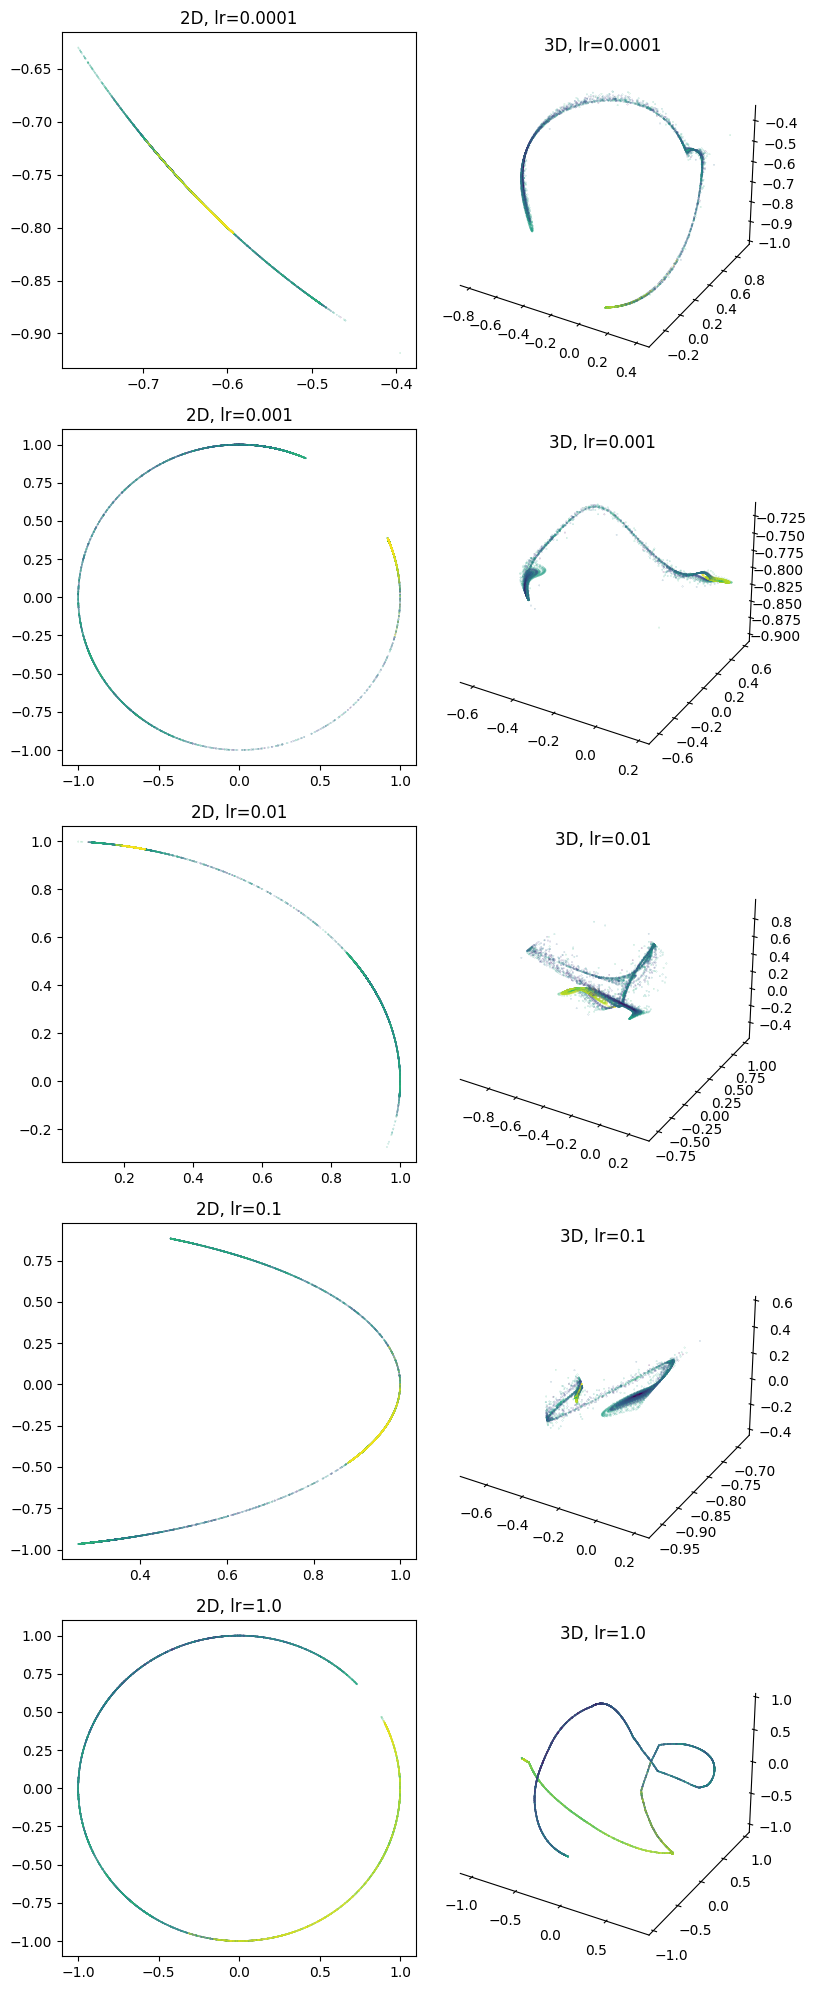

In [23]:
# try it on the lorenz input
opt_lr(new_lorenz,lrs,delta=1, s=0.01)

## 4. Refined Grid Search

After getting an intuition for what values could be good estimates for the parameters in the CEBRA model to compute embeddings for the circle and lorenz attractor inputs, we go ahead and make a grid search over a range of these values to narrow down our search.

In [24]:
# perform a grid search
# 1. Define the parameters, either variable or fixed
params_grid = dict(
    learning_rate = [0.0001,0.001,0.01,0.1,1],
    delta=[0.0001,0.001,0.01,0.1,1],
    temperature=[0.1,1,10,100,500],
    distance='euclidean',
    output_dimension=3,
    max_iterations=[1000], 
    verbose = False)

# try max iterations=5000 later
# try cosine later

# 2. Define the datasets to iterate over
datasets = {"dataset1": circle} # try both circle and lorenz later

# 3. Create and fit the grid search to your data
grid_search = cebra.grid_search.GridSearch()
grid_search.fit_models(datasets=datasets, params=params_grid, models_dir="saved_models_simple")

/Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/lib/python3.11/site-packages/cebra/__init__.py:118: UserWarning: Your code triggered a lazy import of cebra.grid_search. While this will (likely) work, it is recommended to add an explicit import statement to you code instead. To disable this warning, you can run ``cebra.allow_lazy_imports()``.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# 4. Get the results
df_results = grid_search.get_df_results(models_dir="saved_models_simple")

# 5. Get the best model for a given dataset
best_model, best_model_name = grid_search.get_best_model(dataset_name="dataset1", models_dir="saved_models_simple")

These are the suggested values to use as parameters when using a circle as input.

In [ ]:
best_model.get_params()

{'batch_size': None,
 'conditional': None,
 'criterion': 'infonce',
 'delta': 0.1,
 'device': 'cuda_if_available',
 'distance': 'euclidean',
 'hybrid': False,
 'learning_rate': 0.1,
 'max_adapt_iterations': 500,
 'max_iterations': 1000,
 'min_temperature': 0.1,
 'model_architecture': 'offset1-model',
 'num_hidden_units': 32,
 'optimizer': 'adam',
 'optimizer_kwargs': (('betas', (0.9, 0.999)),
  ('eps', 1e-08),
  ('weight_decay', 0),
  ('amsgrad', False)),
 'output_dimension': 3,
 'pad_before_transform': True,
 'temperature': 0.1,
 'temperature_mode': 'constant',
 'time_offsets': 1,
 'verbose': False}

In [ ]:
# perform a grid search
# 1. Define the parameters, either variable or fixed
params_grid_l = dict(
    learning_rate = [0.0001,0.001,0.01,0.1,1],
    delta=[0.0001,0.001,0.01,0.1,1],
    temperature=[0.1,1,10,100,500],
    distance='euclidean',
    output_dimension=3,
    max_iterations=[1000], 
    verbose = False)

# try max iterations=5000 later
# try cosine later

# 2. Define the datasets to iterate over
datasets_l = {"dataset2": new_lorenz} # try both circle and lorenz later

# 3. Create and fit the grid search to your data
grid_search_l = cebra.grid_search.GridSearch()
grid_search_l.fit_models(datasets=datasets_l, params=params_grid_l, models_dir="saved_models_simple")

In [ ]:
# 4. Get the results
df_results_l = grid_search_l.get_df_results(models_dir="saved_models_simple")

# 5. Get the best model for a given dataset
best_model_l, best_model_name_l = grid_search_l.get_best_model(dataset_name="dataset2", models_dir="saved_models_simple")

In [ ]:
best_model_name_l

'delta_1_learning_rate_0.01_temperature_0.1_dataset2'

These are the suggested values to use as parameters when using the lorenz attractor as input.

In [ ]:
best_model_l.get_params()

{'batch_size': None,
 'conditional': None,
 'criterion': 'infonce',
 'delta': 1,
 'device': 'cuda_if_available',
 'distance': 'euclidean',
 'hybrid': False,
 'learning_rate': 0.01,
 'max_adapt_iterations': 500,
 'max_iterations': 1000,
 'min_temperature': 0.1,
 'model_architecture': 'offset1-model',
 'num_hidden_units': 32,
 'optimizer': 'adam',
 'optimizer_kwargs': (('betas', (0.9, 0.999)),
  ('eps', 1e-08),
  ('weight_decay', 0),
  ('amsgrad', False)),
 'output_dimension': 3,
 'pad_before_transform': True,
 'temperature': 0.1,
 'temperature_mode': 'constant',
 'time_offsets': 1,
 'verbose': False}

Now let's try out the suggested parameter values and generate embeddings for both inputs

In [27]:
# ideal model for circle and lorenz inputs
ideal_model, ideal_embedding = base_embed(input=circle, temp=1, dimension=3, lr = 0.1, d=0.1) 
ideal_model_l, ideal_embedding_l = base_embed(input=new_lorenz, temp=1,dimension=3, lr=0.01, d=1)

pos:  0.0000 neg:  6.2297 total:  6.2297 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 92.24it/s]
pos:  0.0012 neg:  5.7531 total:  5.7543 temperature:  1.0000: 100%|██████████| 2000/2000 [00:21<00:00, 93.22it/s]


<Axes3D: title={'center': 'Lorenz Attractor'}>

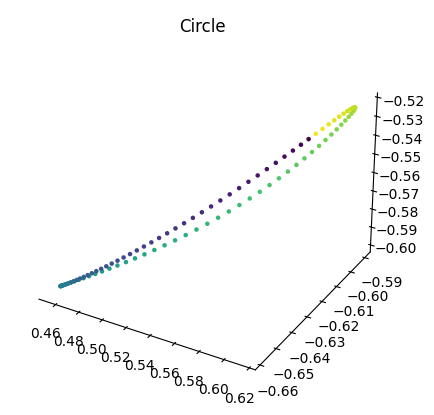

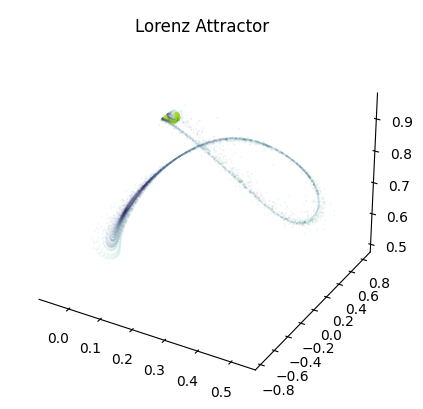

In [29]:
cebra.plot_embedding(ideal_embedding, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(ideal_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

Let's try find the best angle

In [53]:
from mpl_toolkits.mplot3d import Axes3D

# function to view the ideal embedding from different angles
def view_embed(ideal_embedding, n_angles=6):

    fig1=plt.figure(figsize=(8,4*n_angles))
    gs = gridspec.GridSpec(n_angles, 2, figure=fig1)

    for i, ii in enumerate(range(0,360,int(360/n_angles))):

        ax1 = fig1.add_subplot(gs[1*i,0], projection='3d')
        ax1.view_init(elev=10., azim=ii)
        cebra.plot_embedding(ideal_embedding, embedding_labels='time', ax=ax1, markersize=5, alpha=1, title='Circle: {}'.format(ii))

        ax2 = fig1.add_subplot(gs[1*i,1], projection='3d')
        ax2.view_init(elev=10., azim=ii)
        cebra.plot_embedding(ideal_embedding_l, embedding_labels='time',ax=ax2, markersize=0.001, alpha=1, title='Lorenz Attractor: {}'.format(ii))
        
        plt.tight_layout()

    plt.show()
    

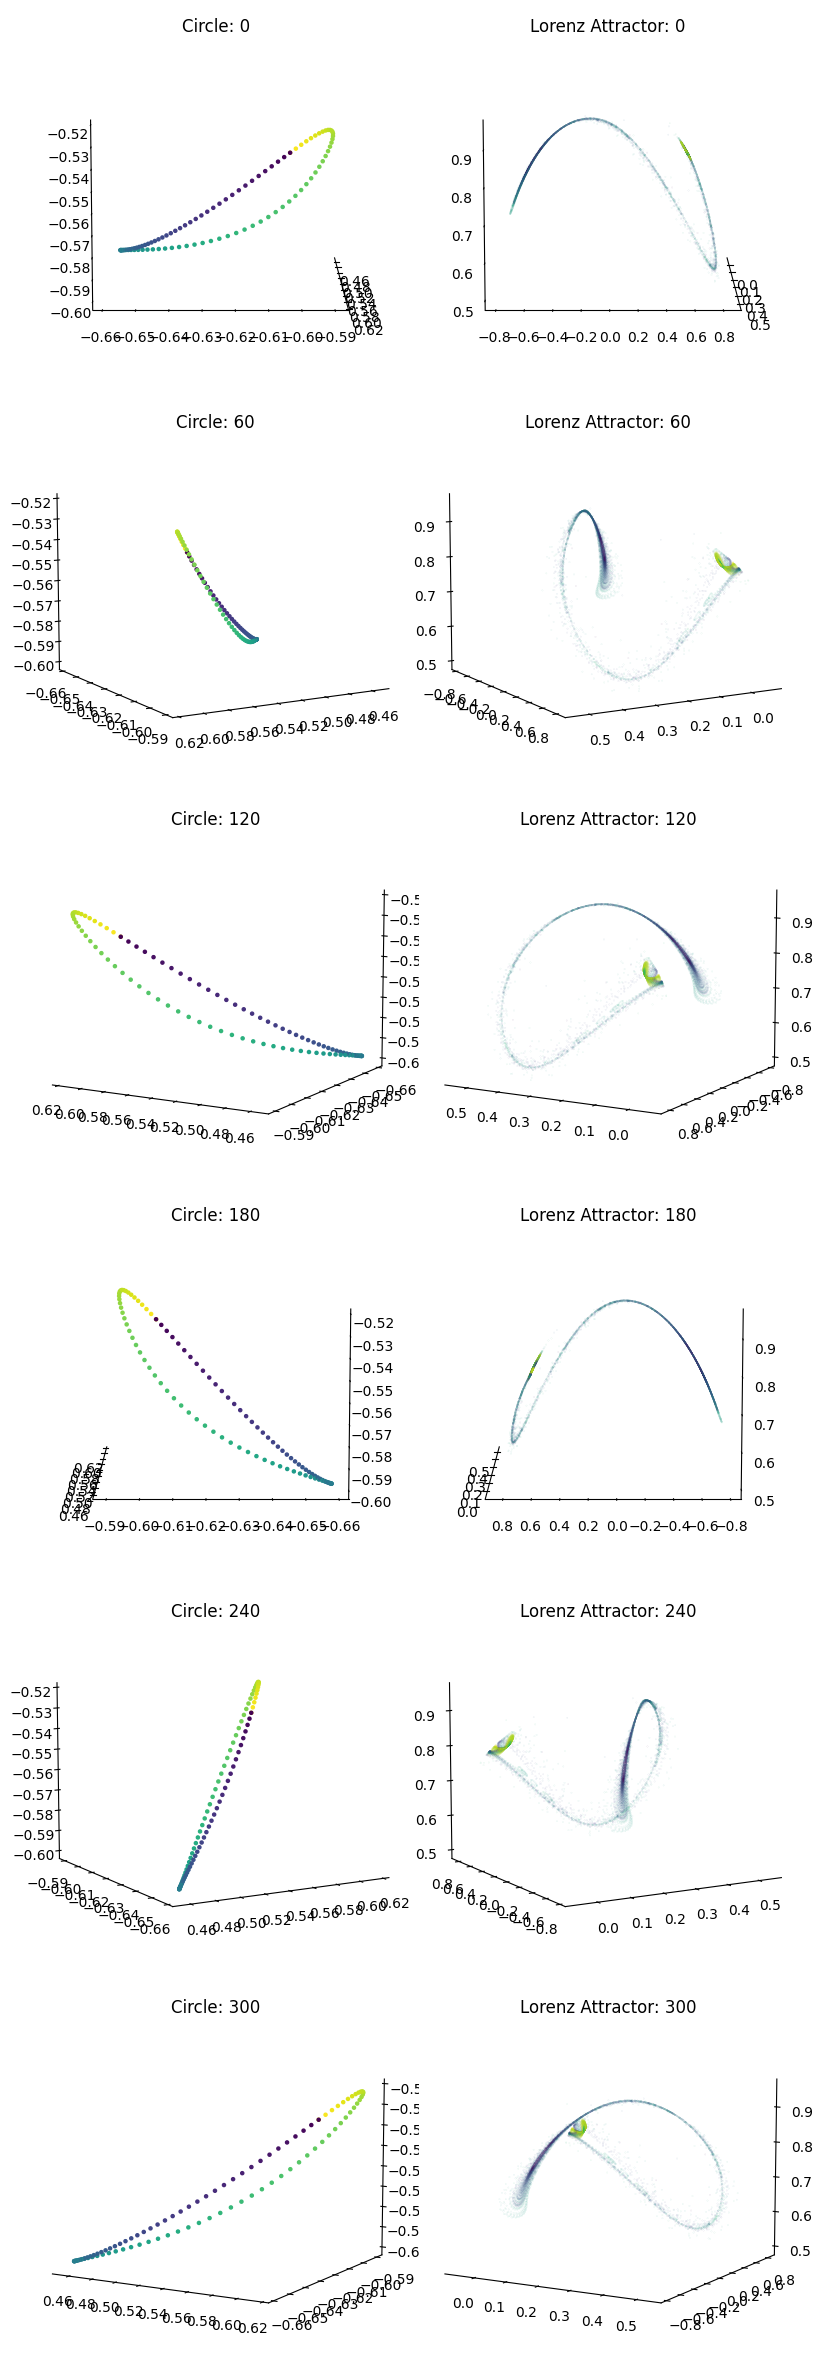

In [54]:
view_embed(ideal_embedding)

We retrieve the circle just fine, but we're still struggling with the lorenz attractor. One thing that could be checked further is the effect of changing the model architecture used. Here we used the model: offset1-model (and checked the offset1-model-mse that gave similar results).